# Simulating a 2D image and error analysis using the object API

Thanks to some inspired thinking by a colleague - left anonymous, to protect the innocent - I am going to try the name "the object API" - and variants thereof - to describe what I've previously called the "low-level API". That is, the
API you get from using the Sherpa classes directly, rather than the routines in `sherpa.ui` or `sherpa.astro.ui`.

To celebrate this new name, I'm going to show how to simulate an image - i.e. model a 2D data set and then add in some noise - then fit it, calculating errors on the fit parameters, and
displaying the results.

As well as `Sherpa` and `matplotlib`, this notebook requires that `scipy` is also installed (but it's not a major component of the analysis so it can be skipped if you don't have it). If you have 
[anaconda or miniconda](https://www.continuum.io/downloads)
installed then you can set up an environment to run this notebook with the following commands (assuming a bash shell):

    % conda create -n=sherpa-notebooks -c sherpa sherpa python=3.9 astropy matplotlib scipy jupyterlab
    ...
    % conda activate sherpa-notebooks
    % git clone https://github.com/DougBurke/sherpa-standalone-notebooks
    ...
    % cd sherpa-standalone-notebooks
    % jupyter lab
    
and then select the "6 simulating a 2D image and a bit of error analysis" option from the web page that should be displayed in your web browser.

## WARNING

This notebook is effectively unusable when run on the myBinder system (a number of steps take a long time to run).

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on June 19 2015. This notebook, and others that may be of
interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra
X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository or on Twitter - at 
[@doug_burke](https://twitter.com/doug_burke) - if you have any questions. 

## Follow up

The notebook has been updated to reflect changes in Sherpa.

## Last run

When was this notebook last run?

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2021-12-21 12:30'

In [2]:
import sherpa
sherpa.__version__

'4.14.0'

## Setting up the environment

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
%matplotlib inline

In [5]:
np.random.seed(1)

## Creating a 2D model

As I am going to simulate an image, I need to define the coordinates
to be used. I could use "pixel" coordinates (e.g. 0 to n-1), but that's not
very interesting, so I have decided to pick a grid with X values between 3000
and 4000, and Y values 4000 to 4800. To keep things simple, I am going to use
square pixels, of side 5, and I am also going to use the Sherpa naming scheme
for the independent axes, so that X is represented by `x0`, and Y is represented
by `x1` (for Sherpa, `y` is the dependent axis). The choice of variable names is
not relevant to Sherpa, but I wanted to keep a consistent scheme since I end
up using `x0`, `x1`, and `y` attributes later on in the notebook.

This all means that I want:

In [6]:
x1low = 4000
x1high = 4800

x0low = 3000
x0high = 4000

dx = 5

x1,x0 = np.mgrid[x1low:x1high:dx, x0low:x0high:dx]

This turns into a 200 by 160 pixel grid - as shown by

In [7]:
x0.shape

(160, 200)

which is a reasonable size for testing and development (there's only so long I can re-run these commands when writing the notebook!). The coordinates are going to be the points at which the model is evaluated; I am going to consider them to be the center of each pixel - so that the X range of the image is actually 2997.5 to 4002.5, going from left edge to right edge - but it doesn't really matter as long as you remain consistent in your interpretation$^\dagger$. Note that I am using the support for "unbinned" images in sherpa - that is, evaluate the model at a single point, rather than integrate it over the pixel - so the interpretation of the coordinate positions is important to understand. 

$^\dagger$ if I were using [ds9 image visualizer](http://ds9.si.edu/) to display images - using the optional DS9 image backend in Sherpa - then the converntion would matter, since Sherpa/DS9 make the same assumption on coordinates that I do. 

Now that I have a grid, I can define one or more Sherpa model components, and pass them the coordinate grid to create a simulated model. For this notebook I am going to use the sum of two "2D beta" profiles, which is an Astronomy specific name for a profile with a radial variation of

$$f(r) \propto (1 + (r/r_0)^2)^{-\alpha}$$
    
The model supports an elliptical profile, but I am going to use the circular form, and have the centers of the two components be the same. The important parameters are therefore: the core radius (`r0`), which sets the scale of the emission; the `alpha` parameter which determines the slope at large radii (where it's $f(r) \sim r^{-2\alpha}$); and the normalisation (`ampl`):

In [8]:
from sherpa.astro.models import Beta2D

cpt1 = Beta2D('cpt1')
cpt2 = Beta2D('cpt2')
model = cpt1 + cpt2

model

<BinaryOpModel model instance '(cpt1 + cpt2)'>

The model classes contain documentation on the model and parameters, as shown below:

In [9]:
help(Beta2D)

Help on class Beta2D in module sherpa.astro.models:

class Beta2D(sherpa.models.model.RegriddableModel2D)
 |  Beta2D(name='beta2d')
 |  
 |  Two-dimensional beta model function.
 |  
 |  The beta model is a Lorentz model with a varying power law.
 |  
 |  Attributes
 |  ----------
 |  r0
 |      The core radius.
 |  xpos
 |      X0 axis coordinate of the model center (position of the peak).
 |  ypos
 |      X1 axis coordinate of the model center (position of the peak).
 |  ellip
 |      The ellipticity of the model.
 |  theta
 |      The angle of the major axis. It is in radians, measured
 |      counter-clockwise from the X0 axis (i.e. the line X1=0).
 |  ampl
 |      The model value at the peak position (xpos, ypos).
 |  alpha
 |      The power-law slope of the profile at large radii.
 |  
 |  See Also
 |  --------
 |  Beta1D, DeVaucouleurs2D, HubbleReynolds, Lorentz2D, Sersic2D
 |  
 |  Notes
 |  -----
 |  The functional form of the model for points is::
 |  
 |      f(x0,x1) = ampl

I am going to place the source near the center of the grid, but offset slightly, with the first component representing a bright core (large `ampl`, small `r0`, and large `alpha`, so that the emission is centrally concentrated), and the second component is an extended component (larger `r0`, smaller `alpha` so that the emission is "flatter", and a lower amplitude):

In [10]:
cpt1.xpos, cpt1.ypos = 3512, 4418
cpt2.xpos, cpt2.ypos = cpt1.xpos, cpt1.ypos

cpt1.r0, cpt2.r0 = 30, 120
cpt1.alpha, cpt2.alpha = 4.2, 2.1

cpt1.ampl, cpt2.ampl = 45, 10

model

<BinaryOpModel model instance '(cpt1 + cpt2)'>

Oops - after going on above that Sherpa uses `x0` and `x1` for the independent axes, I then go and show you a model where the position is labelled `xpos` and `ypos`. Oh well!

Evaluating the model is just a case of passing in the coordinate grid (so the X and Y axis values) to the model. The axes are assumed to be in 1D format (since you do not have to evaluate the full grid, if you only want a non-rectangular set of points), which means
converting back and forth between 1D and 2D data sets (`flatten` to go from 2D to 1D and `resize` to go the other way). I've called the model `mexp` as it is the expected values for this model (as I'm about to go and add noise to it):

In [11]:
mexp = model(x0.flatten(), x1.flatten())
mexp.resize(x0.shape)

If I were using the UI level of Sherpa, and not using an IPython notebook, then I would use the `sherpa.ui.image_data` command to view the data. This brings up the data in an external 
viewer - the [DS9 imaging and data visualization application](http://ds9.si.edu/) - if installed, which allows you to adjust and interact with the data (e.g. to change the color scale and dynamic scaling of the data). For this notebook I am going to use the imaging
support in `matplotlib`. Here's a view of the evaluated model, using a linear scale (left) and 
arcsinh scaling (right; based on the work of [Lupton, Gunn & Szalay (1999)](http://adslabs.org/adsabs/abs/1999AJ....118.1406L/)). A central source can be seen, that extends out across the image, but the dynamic range is such that it's hard to see the data at the edges and the core.

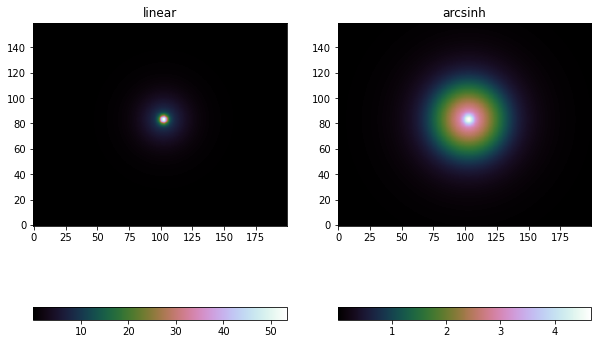

In [12]:
plt.figure(figsize=(10, 10))

plt.subplot(1,2,1)
plt.imshow(mexp, origin='lower', cmap='cubehelix')
plt.colorbar(orientation='horizontal')
plt.title('linear')

plt.subplot(1,2,2)
plt.imshow(np.arcsinh(mexp), origin='lower', cmap='cubehelix')
plt.colorbar(orientation='horizontal')
plt.title('arcsinh');

From the lefthand plot I can see that the data ranges from 0 to about 50, but what's the exact range?

In [13]:
print("Stats: min = {}  max = {}".format(mexp.min(), mexp.max()))

Stats: min = 0.007215205702565074  max = 53.34646802646546


## Simulating data

I want to simulate this image using Poisson statistics, which is fortunately very easy
to do, using [`numpy.random.poisson`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.poisson.html):

In [14]:
msim = np.random.poisson(mexp)
print("Stats: min = {}  max = {}".format(msim.min(), msim.max()))

Stats: min = 0  max = 64


Unsurprisingly, the result isn't quite as smooth as the model! The quantized nature of the data (all pixels have integer values) does mean that it's a bit easier to see the extended emission than in the earlier plots.

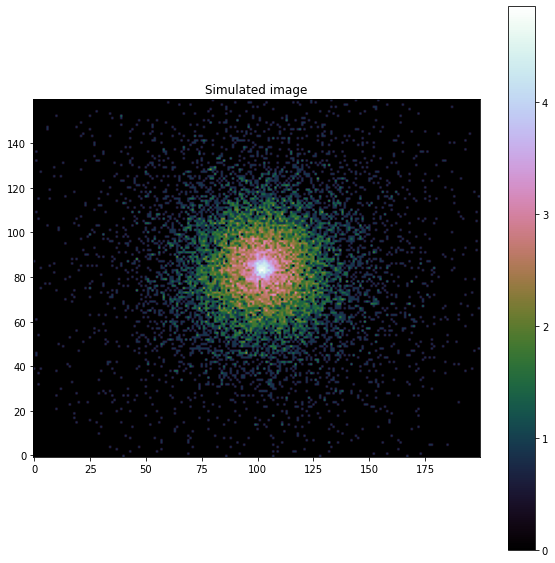

In [15]:
plt.figure(figsize=(10, 10))

plt.imshow(np.arcsinh(msim), origin='lower', cmap='cubehelix')
plt.title('Simulated image')
plt.colorbar();

As I have coordinates for the two axes, let's try and include them in the plots (I'm also already tired of setting the `origin` and `cmap` keywords). I'm not particularly proud of these routines, as they do rely on hidden state - e.g. the `extent` array - but they work well in this notebook!

In [16]:
x0min, x0max = x0.min(), x0.max()
x1min, x1max = x1.min(), x1.max()
extent = [x0min - dx/2, x0max + dx/2, x1min - dx/2, x1max + dx/2]

def image_data(idata, transform=np.arcsinh, **kwargs):
    """Create an image of idata, which is assumed to be an array of
    the same size as x and y. The data is passed through transform,
    which defaults to np.arcsinh, if not None.
    """
    if transform is not None:
        idata = transform(idata)
        
    plt.imshow(idata, extent=extent, origin='lower', cmap='cubehelix', **kwargs)
    
def image_model(imodel, transform=np.arcsinh, **kwargs):
    """Create an image of the given model, using the x and y grids.
    
    The transform argument is applied to the data before display, if not None.
    The default is np.arcsinh.
    """
    idata = imodel(x0.ravel(), x1.ravel()).reshape(x0.shape)
    image_data(idata, transform=transform, **kwargs)

# because I'm going to want them later on
def vline(x):
    (yl,yh) = plt.ylim()
    plt.ylim(yl, yh) # force limits
    plt.vlines(x, yl, yh)

def hline(y):
    (xl,xh) = plt.xlim()
    plt.xlim(xl, xh)
    plt.hlines(y, xl, xh)

Using these, I can display the simulated data:

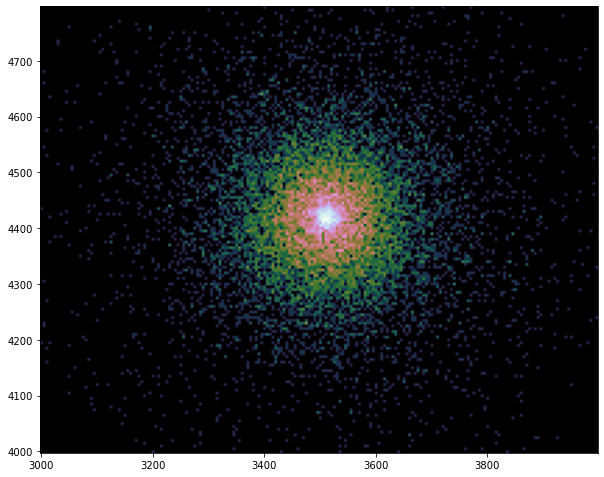

In [17]:
plt.figure(figsize=(10, 10))

image_data(msim)

I can also compare the simulated data (top left) to the full model (bottom left) and the individual components (right column):

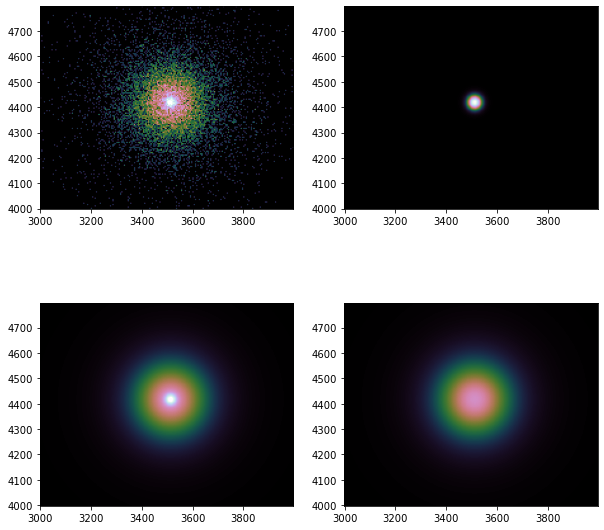

In [18]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
image_data(msim, vmin=0, vmax=4.5)

plt.subplot(2,2,3)
image_model(model, vmin=0, vmax=4.5)

plt.subplot(2,2,2)
image_model(cpt1, vmin=0, vmax=4.5)

plt.subplot(2,2,4)
image_model(cpt2, vmin=0, vmax=4.5)

## Fitting the data

To fit a model to the simulated data I need a data set (`Data2D`), statistic (in this case the `Cash` statistic, a Maximum Likelihood statistic for Poisson data, from
"[Parameter estimation in astronomy through application of
 the likelihood ratio](http://adsabs.harvard.edu/abs/1979ApJ...228..939C)", Cash, W. 1979, ApJ 228, 939), optimisation method (`NelderMead`), and the `Fit` object to control it all.

In [19]:
from sherpa.data import Data2D
from sherpa.stats import Cash
from sherpa.optmethods import NelderMead
from sherpa.fit import Fit

To start off, I create the data object. It needs a name, the independent axes (`x0` and `x1`), the dependent axis (`msim`), and then I also give the shape of the image. The shape isn't required here, but I do take advantage of it later on- in cell 29 - when creating images. Although in this case the grid is rectangular, with no missing data, Sherpa will happily accept sparse, or irregularly gridded, data.

In [20]:
d = Data2D('sim', x0.flatten(), x1.flatten(), msim.flatten(), shape=x0.shape)

I am going to fit the simulated image with the same model used to create it. I access the components using the `parts` attribute of the combined model - mainly to show that it can be done, since in this case there's no real benefit over writing the more-obvious form:

    m1 = Beta2D('m1')
    m2 = Beta2D('m2')
    mdl_fit = m1 + m2

In [21]:
mdl_fit = Beta2D('m1') + Beta2D('m2')
(m1, m2) = mdl_fit.parts

The default parameters - which are the same as in cell 7 - are not close to the best-fit parameters. Even worse, the two components have the same starting values, which means that the optimiser is going to have a tough time disentangling the two components. There's a number of ways I could calculate starting values for these parameters, and if I were doing this on real data I'd be interested to see how sensitive the fit is to the starting position, to make sure I had found the global minimum$^\dagger$.

I am going to set the peak position to the peak of the distribution - formed by summing the data up over the rows and columns, respectively - then use a completely ad-hoc guess for the core radii and amplitudes, based on the image extent and data values. First, I create the profiles along the X and Y axes.

$^\dagger$ In early versions of this notebook I did try starting from the default values. It required several fits and tweaks to nudge the fit into a good solution. Since my aim here is not to discuss the fine details of model fitting, and also because the previous approach took a long time to converge, I've decided to "help out" the optimiser.

In [22]:
ysum = msim.sum(axis=0)
xsum = msim.sum(axis=1)

With these arrays, I can find the coordinate of the maximum point:

In [23]:
xguess = x0[0, np.argmax(ysum)]
yguess = x1[np.argmax(xsum), 0]

This can perhaps be seen better graphically (note that the actual center is 3512,4418, but
the grid is evaluated only every 5 pixels, which is why the guesses are both divisible by 5).

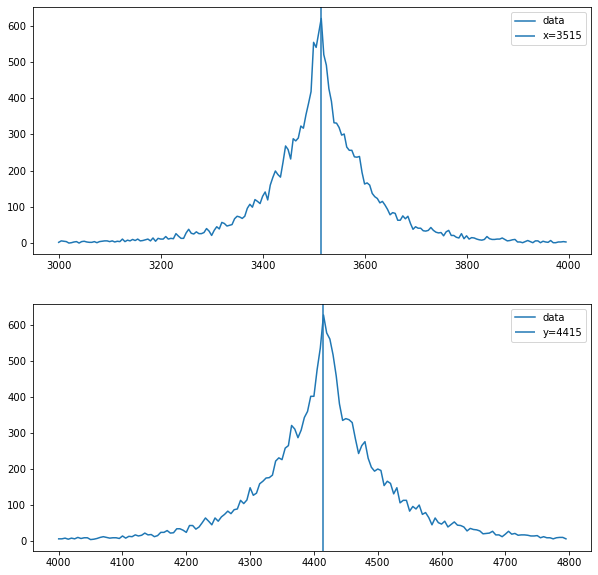

In [24]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(x0[0,:], ysum)
vline(xguess)
plt.legend(['data', 'x={}'.format(xguess)])

plt.subplot(2, 1, 2)
plt.plot(x1[:,0], xsum)
vline(yguess)
_ = plt.legend(['data', 'y={}'.format(yguess)])

I use this value for the position, and link the second component so that it uses the same values:

In [25]:
m1.xpos = xguess
m1.ypos = yguess
m2.xpos = m1.xpos
m2.ypos = m1.ypos

I am going to define the first component to have an amplitude equal to the maximum pixel
value in the data, and the second one to be one-tenth that (this is completely arbitrary).

If I had said

    m2.ampl = m1.ampl / 10.0
    
then the amplitude of the second component would have been fixed to be one-tenth that of the first (that is, parameters can be linked by an expression, not just a value).

In [26]:
m1.ampl = msim.max()
m2.ampl = msim.max() / 10.0

The core radii are taken from the height of the image (since it's the smallest axis):

In [27]:
m1.r0 = (x1max - x1min) / 10.0
m2.r0 = (x1max - x1min) / 4.0

The resulting set of parameters is:

In [28]:
mdl_fit

<BinaryOpModel model instance '(m1 + m2)'>

Note that the `m2.xpos` and `m2.ypos` parameters are marked as `linked`; that is, they are not free parameters themselves but are calculated from an expression based on other parameters (in this case the position of the first component).

The fit is started by creating a `Fit` object, giving the data, model, statistic, and optimization method (`LevMar` is generally faster than `NelderMead` but it isn't really suited to this type of statistic, and will often stop prematurely).

In [29]:
f = Fit(d, mdl_fit, Cash(), NelderMead())

This has not performed a fit yet! For that, I need to call the `fit` method, which can take some time:

In [30]:
res1 = f.fit()
res1

Parameter,Best-fit value
m1.r0,43.4249
m1.xpos,3511.63
m1.ypos,4418.26
m1.ampl,43.0807
m1.alpha,8.29419
m2.r0,116.631
m2.ampl,10.3843
m2.alpha,2.06942


I am going to repeat the fit, to check that the optimiser hasn't stopped early, and also to show how to change the format of the return value of the `fit` method:

In [31]:
res2 = f.fit()
print(res2.format())

Method                = neldermead
Statistic             = cash
Initial fit statistic = 1968.05
Final fit statistic   = 1968.05 at function evaluation 589
Data points           = 32000
Degrees of freedom    = 31992
Change in statistic   = 3.07536e-07
   m1.r0          43.4305     
   m1.xpos        3511.63     
   m1.ypos        4418.26     
   m1.ampl        43.0803     
   m1.alpha       8.29622     
   m2.r0          116.63      
   m2.ampl        10.3844     
   m2.alpha       2.06941     


The second fit only changed the statistic by a very small amount ($\ll 10^{-5}$) which suggests that the fit is in a local minimum.

How can I visualize this? First, I evaluate the model, using the `eval_model` method of the data set:

In [32]:
meval = d.eval_model(mdl_fit).reshape(d.shape)

I could have given the grid to `mdl_fit` directly - as I did when creating `msim` and `mexp` - but wanted to show how to use the dataset. This also takes advantage of the `shape` attribute I set up when calling `Data2D` in cell 19.

I can use the routines I set up earlier to display the best-fit model:

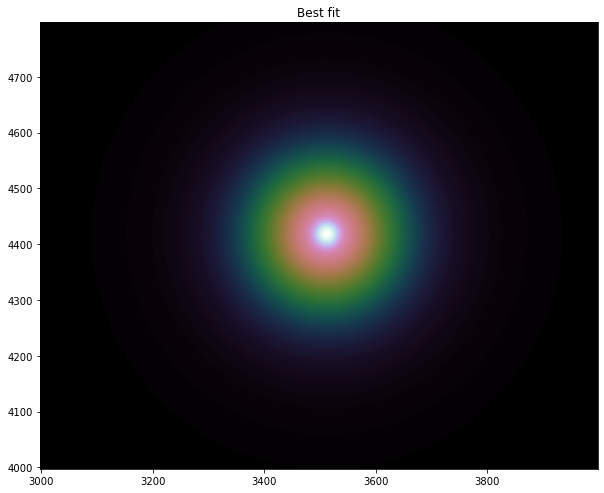

In [33]:
plt.figure(figsize=(10, 10))

image_data(meval)
plt.title('Best fit');

I can also view the residuals - i.e. `data - model` - this time with no transform as the range of values is small and is centered on zero:

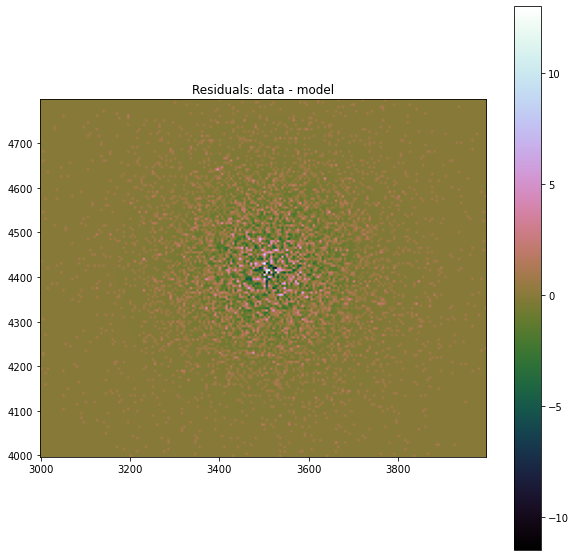

In [34]:
plt.figure(figsize=(10, 10))

image_data(msim - meval, transform=None)
plt.title('Residuals: data - model')
plt.colorbar();

Interpreting this residual image can be hard, since the variation is larger where the signal is larger, but is there any statistically-significant structure here? I would normally try things like smoothing the residuals, looking for structure, and comparing to the model and data. For now, let's just look at a heavily-smoothed version if the residuals (taking advantage of
[SciPy's `gaussian_filter` function](http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.filters.gaussian_filter.html#scipy.ndimage.filters.gaussian_filter)).

In [35]:
from scipy import ndimage

In [36]:
smoothed = ndimage.gaussian_filter(msim - meval, sigma=(5, 5), order=0)

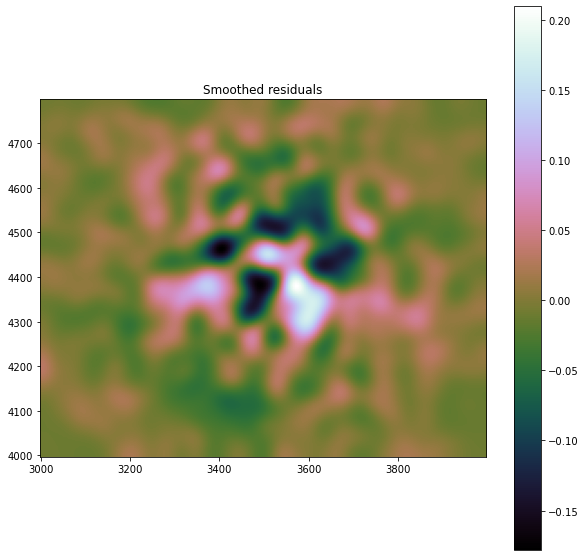

In [37]:
plt.figure(figsize=(10, 10))

image_data(smoothed, transform=None)
plt.title('Smoothed residuals')
plt.colorbar();

Note that, due to the heavy smoothing, the scale (the dynamic range of the image) is significantly smaller than the previous residual plot. We can compare the two with the same scale, but the result isn't particularly compelling (I think it's saying there's not much structure in the residuals, which is unsurprising given that this is a simulation).

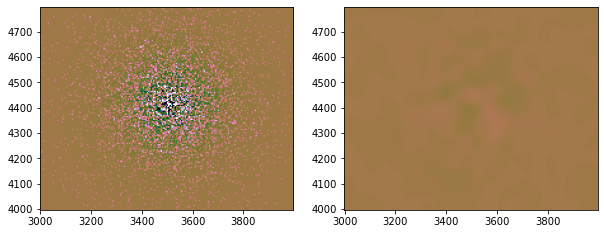

In [38]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
image_data(msim - meval, transform=None, vmin=-5, vmax=5)

plt.subplot(1, 2, 2)
image_data(smoothed, transform=None, vmin=-5, vmax=5)

One other simple check is to look at the signal in the residuals: in this case, it is very close to 0 (which again suggests that the model has accounted for the features in the data).

In [39]:
print("Sum of residuals: {}".format((msim-meval).sum()))

Sum of residuals: -2.8274686485474376e-06


## Error analysis

Having parameter values isn't really enough; I want some level of error bar or confidence range on their values. For this, I am going to use the `Confidence` object provided by Sherpa (the other main choice would be `Covariance`, but I find `Confidence` to be more robust).

In [40]:
from sherpa.estmethods import Confidence

Now, before starting the error analysis, I am going to change the optimisation method from
`NelderMead` - that is:

In [41]:
f.method

<NelderMead optimization method instance 'simplex'>

to the Levenberg-Marquardt method (`LevMar`). This is just to speed up the error analysis *for this notebook* since, as mentioned previously, `Levmar` tends to be faster than `NelderMead`. Since the fits are starting off "in a good place" (i.e. at the local minimum), the fact that `LevMar` can stop early should not be a serious problem. However, if I were writing a paper based on this analysis I would likely stick with `NelderMead` (or at least run some tests)!

In [42]:
from sherpa.optmethods import LevMar

In [43]:
f.method = LevMar()

With this, and after setting the `estmethod` attribute, the `est_errors` method can be called to evaluate errors for all the free parameters, which can unfortunately take quite some time to complete (and, if you have multiple cores on your machine, give them all a quick exercise): 

In [44]:
f.estmethod = Confidence()
eres = f.est_errors()
eres

m1.ypos lower bound:	-0.392626
m1.xpos lower bound:	-0.395429
m1.ypos upper bound:	0.392626
m1.xpos upper bound:	0.395429
m2.r0 lower bound:	-3.18785
m1.ampl lower bound:	-2.5475
m2.ampl lower bound:	-0.336498
m1.r0 lower bound:	-14.1717
m1.alpha lower bound:	-4.0183
m2.ampl upper bound:	0.296526
m2.r0 upper bound:	3.52205
m1.ampl upper bound:	3.11721
m2.alpha lower bound:	-0.0402557
m1.alpha upper bound:	80.0679
m1.r0 upper bound:	6.38777
m2.alpha upper bound:	0.0430684


Parameter,Best-fit value,Lower Bound,Upper Bound
m1.r0,43.4305,-14.1717,6.38777
m1.xpos,3511.63,-0.395429,0.395429
m1.ypos,4418.26,-0.392626,0.392626
m1.ampl,43.0803,-2.5475,3.11721
m1.alpha,8.29622,-4.0183,80.0679
m2.r0,116.63,-3.18785,3.52205
m2.ampl,10.3844,-0.336498,0.296526
m2.alpha,2.06941,-0.0402557,0.0430684


As with the `fit` method, the return value can be displayed nicely using its `format` method:

In [45]:
print(eres.format())

Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   m1.r0             43.4305     -14.1717      6.38777
   m1.xpos           3511.63    -0.395429     0.395429
   m1.ypos           4418.26    -0.392626     0.392626
   m1.ampl           43.0803      -2.5475      3.11721
   m1.alpha          8.29622      -4.0183      80.0679
   m2.r0              116.63     -3.18785      3.52205
   m2.ampl           10.3844    -0.336498     0.296526
   m2.alpha          2.06941   -0.0402557    0.0430684


How do these compare to the input values - i.e. those of the `cpt1` and `cpt2` models? First, I write a small routine to find the corresponding value given the name of the component used in the fit (mapping `m1` to `cpt1` and `m2` to `cpt2`):

In [46]:
def get_input_val(fullname):
    (minst,parname) = fullname.split(".")
    if minst == "m1":
        cpt = cpt1
    elif minst == "m2":
        cpt = cpt2
    else:
        raise ValueError("Unrecognized model: {}".format(fullname))
        
    return getattr(cpt, parname).val


A quick check that it works:

In [47]:
get_input_val('m2.alpha')

2.1

This can be usd to loop through the data in the `eres` object, calculating the
separation of the true value (`actual`) from the best-fit location. Since the errors are not symmetrical, the upper or lower error is used to create an error-normalised distance (as the
error analysis used the default settings, these errors refer to one-sigma values).

In [48]:
for (fullname, fitval, fitlo, fithi) in \
    zip(eres.parnames, eres.parvals, eres.parmins, eres.parmaxes):
        actual = get_input_val(fullname)
        ediff = actual - fitval
        if ediff > 0:
            ediff /= fithi
        else:
            ediff /= fitlo

        print("{:10s} should be {:6.1f} and is {:.2f} sigma away".format(fullname,
                                                                         actual, ediff))
    

m1.r0      should be   30.0 and is 0.95 sigma away
m1.xpos    should be 3512.0 and is 0.93 sigma away
m1.ypos    should be 4418.0 and is 0.66 sigma away
m1.ampl    should be   45.0 and is 0.62 sigma away
m1.alpha   should be    4.2 and is 1.02 sigma away
m2.r0      should be  120.0 and is 0.96 sigma away
m2.ampl    should be   10.0 and is 1.14 sigma away
m2.alpha   should be    2.1 and is 0.71 sigma away


So, the values seem to be about one sigma away from the best-fit location, but let's quantify that with a simple histogram:

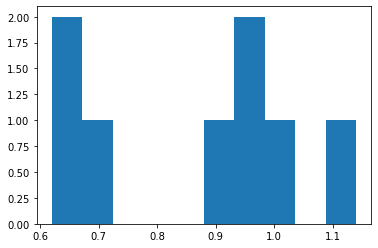

In [49]:
plt.hist([0.95,0.93,0.66,0.62,1.02,0.96,1.14,0.71]);

## Interval Projection (aka sensitivity to a single parameter)

What is the error distribution like for a single parameter? The UI layer of Sherpa provides the `sherpa.ui.interval_projection()` function - also available as `sherpa.ui.int_proj()` as it's a lot easier to type - which displays the statistic value as the parameter is varied. This can be created using the object API, as shown below.

In [50]:
from sherpa.plot import IntervalProjection

An `IntervalProjection` object is created, and the range over which the analysis is to be done is set via the `prepare` method (there are several other options to this method which are not being used here). I chose a range of 10 to 60 given the error analysis 
($43_{-14}^{+6}$) for the `m1.r0` parameter:

In [51]:
iproj = IntervalProjection()
iproj.prepare(min=10, max=60, nloop=41)

With this, we can see how the core radius of the first component varies things. First the calculation, which can take some time:

In [52]:
iproj.calc(f, m1.r0)

With this, a plot can be created; I add on a vertical line indicating the true value for the core radius (this is the solid black line; the vertical dashed line is the best-fit location):

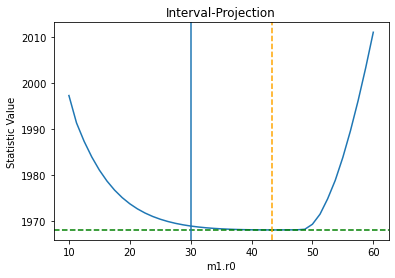

In [53]:
iproj.plot()
vline(cpt1.r0.val)

This can be re-plotted, zooming in on the Y axis (if the error surface is "well behaved" then the one, two, and three sigma error ranges should be given by `smin+1`, `smin+4`, and `smin+9`, which is why I used an upper limit of `smin+10` for the plot):

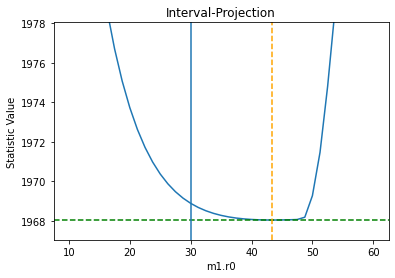

In [54]:
iproj.plot()
smin = f.calc_stat()
plt.ylim(smin-1, smin+10)
vline(cpt1.r0.val)

## Region Projection (this time with two variables)

I can use the `RegionProjection` class to look at how the statistic varies with two parameters - e.g. to look for possible correlations (this is the equivalent of the `sherpa.ui.region_projection` or `sherpa.ui.reg_proj` function).

In [55]:
from sherpa.plot import RegionProjection

As with `IntervalProjection` I need to set up the ranges used. In this case I am going to compare the `alpha` parameters of the two slopes. These have errors of

```
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   m1.alpha          8.29622      -4.0183      80.0679
   m2.alpha          2.06941   -0.0402557    0.0430684
```

which looks to me like it's saying that it can't really constrain the upper bound of `m1.alpha` (as `alpha` gets larger, the slope gets steeper). I choose a range for `m1.alpha` of 1 to 15, to avoid wasting too much time with this possible upper limit.

In [56]:
rproj = RegionProjection()
rproj.prepare(min=[1,1.9], max=[15,2.3], nloop=[21,21])

As in any of these error analysis routines, the run time can be long:

In [57]:
rproj.calc(f, m1.alpha, m2.alpha)

Since this is a 2D data set rather than a 1D one (as `IntervalProjection` created), the display is created by the `contour` method:

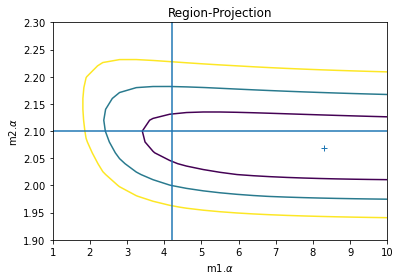

In [58]:
rproj.contour()
plt.xlabel(r'm1.$\alpha$')
plt.ylabel(r'm2.$\alpha$')
vline(cpt1.alpha.val)
hline(cpt2.alpha.val)

The contours give the 1, 2, and 3 sigma surfaces, so we can see that the input values (shown by the solid horizontal and vertical lines) lie within the one-sigma contour. The blue cross - at approximately (8,2.05) - is the best-fit values for the two parameters.

Note that the X axis only goes up to 10, not the 15 I asked for. This is because the default parameter range for alpha is -10 to 10 - this can be found by looking at the `min` and `max` attributes of the parameter:

In [59]:
m1.alpha

Component,Parameter,Thawed,Value,Min,Max,Units
m1,alpha,,8.296216943435446,-10.0,10.0,


I could change this limit - e.g. with

    m1.alpha.max = 20
    
and then re-run `rproj.calc`, but for the purposes of this notebook I am just going to carry on and pretend I only wanted the value up to 10 in the first place.

I can also view the data as an image, since the results include the coordinate values for both axes and the statistic value in each bin. It should not surprise you to know that this data is
in 1D format:

In [60]:
rproj.y.shape

(441,)

I know that the output is a 21 by 21 grid - the `nloop` parameter to prepare - so I can just say

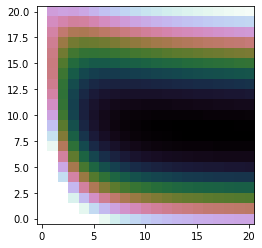

In [61]:
plt.imshow(rproj.y.reshape(21,21) - smin, origin='lower', cmap='cubehelix', vmin=0, vmax=30);

I have subtracted off the best-fit statistic value, so this is now a relative display, and limited the range to 30 - otherwise (in this particular case) the large values at the
edges of the display (in particular at low alpha values) will dominate the display.

I want to include the axis values, rather than pixel numbers, so use the following to
look at what values were chosen:

In [62]:
rproj.x0.reshape(21,21)[0,:]

array([ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
        5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
        9.1 ,  9.55, 10.  ])

In [63]:
rproj.x1.reshape(21,21)[:,0]

array([1.9 , 1.92, 1.94, 1.96, 1.98, 2.  , 2.02, 2.04, 2.06, 2.08, 2.1 ,
       2.12, 2.14, 2.16, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28, 2.3 ])

These values can be used to set up the axes for the plot. Since the scales are very different,
I have to adjust the aspect ratio of the plot to get a sensible display. I can now add in the
contours by taking advantage of the `overplot` and `clearwindow` arguments to the `contour`
method. I have reversed the colormap to make the contours more readable. 

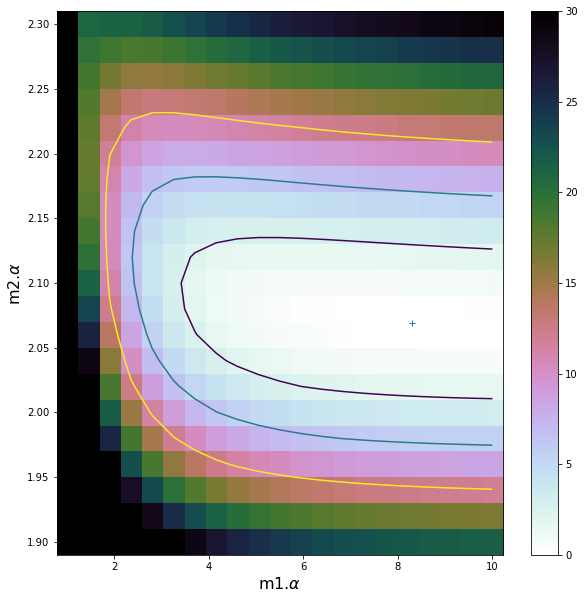

In [64]:
plt.figure(figsize=(10, 10))

extent2 = [1 - 0.45 / 2, 10 + 0.45 / 2, 1.89, 2.31]
plt.imshow(rproj.y.reshape(21,21) - smin, extent=extent2, origin='lower',
           cmap='cubehelix_r', vmin=0, vmax=30)
ax = plt.gca()
ax.set_aspect('auto')
rproj.contour(overplot=True, clearwindow=False)
plt.colorbar()
plt.xlabel(r'm1.$\alpha$', size=16)
plt.ylabel(r'm2.$\alpha$', size=16);